## Load pre-processed adata and impute highly variable genes using MAGIC

In [1]:
import scvelo as scv
import scanpy as sc
import velocyto as vcy
import cellrank as cr
import loompy as lp

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
from pathlib import Path

import numpy as np
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt

import os
import sys
import logging

In [16]:
adata_infile = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/outs/adata_aggregated_gene.leiden.h5ad"
adata_new = '/ocean/projects/cis240075p/skeshari/igvf/bcell1/male_donor/out_data/sc_preproc/out_files/male_sc_processed.h5ad'
objects_path = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/objects_other"

In [11]:
# transfer the file to the scratch space
!rsync -aP $adata_infile $adata_new /dev/shm/

sending incremental file list
male_sc_processed.h5ad
         32,768   0%    0.00kB/s    0:00:00  

  7,400,404,515 100%  444.37MB/s    0:00:15 (xfr#1, to-chk=0/2)


In [44]:
adata = sc.read_h5ad(os.path.join('/dev/shm/', os.path.basename(adata_infile)))
adata_new = sc.read_h5ad(os.path.join('/dev/shm/', os.path.basename(adata_new)))

In [20]:
adata

AnnData object with n_obs × n_vars = 32418 × 23090
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap', 'sub_cell_type_colors'
    obsm: 'X_joint_umap_features', 'X_topic_compositions', 'X_umap', 'X_umap_features'
    varm: 'topic_feature_activations', 'topic_feature_compositions'
    lay

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


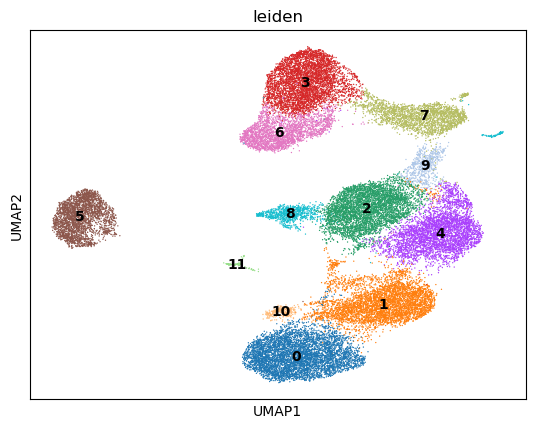

In [7]:
sc.pl.umap(adata, color=['leiden'], legend_loc='on data')

### Add annotation to the adata object


/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


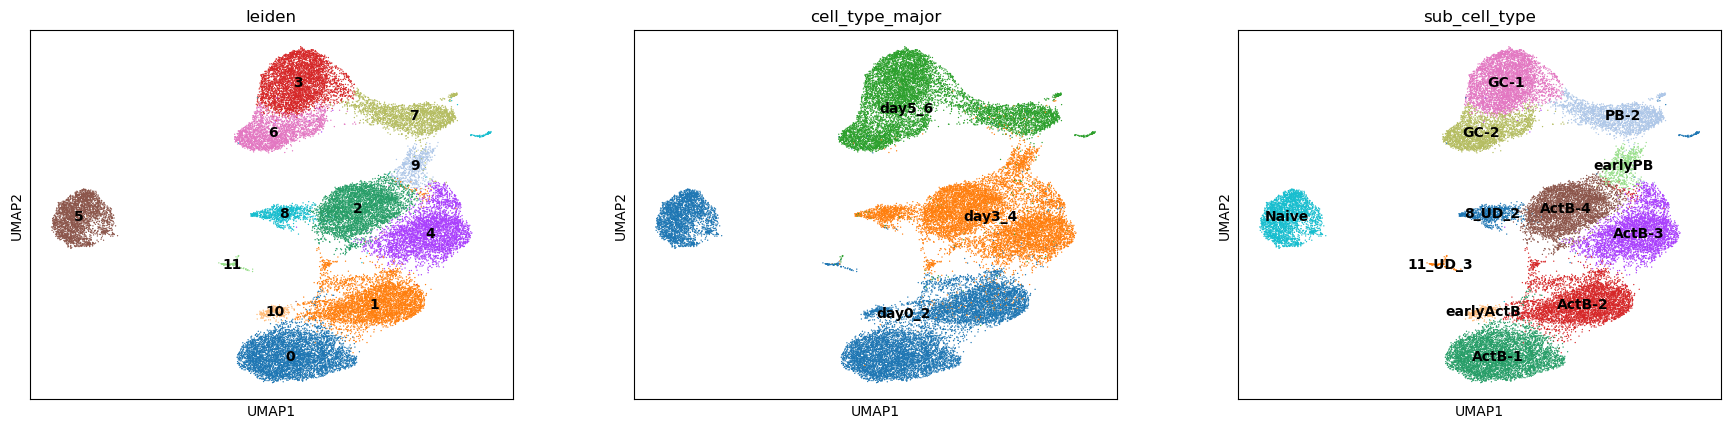

In [17]:
cluster_list = list(set(adata.obs.leiden))
# Annotation 2
annotation_2 = {'5': 'Naive',
                '10': 'earlyActB',
                '9': 'earlyPB',
                '8': '8_UD_2',
                '3': 'GC-1',
                '11': '11_UD_3',
                '1': 'ActB-2',
                '0': 'ActB-1',
                '7': 'PB-2',
                '4': 'ActB-3',
                '6': 'GC-2',
                '2': 'ActB-4'}
adata.obs["sub_cell_type"] = [annotation_2[i] for i in adata.obs.leiden]
sc.pl.umap(adata, color=['leiden','cell_type_major','sub_cell_type'],legend_loc='on data')

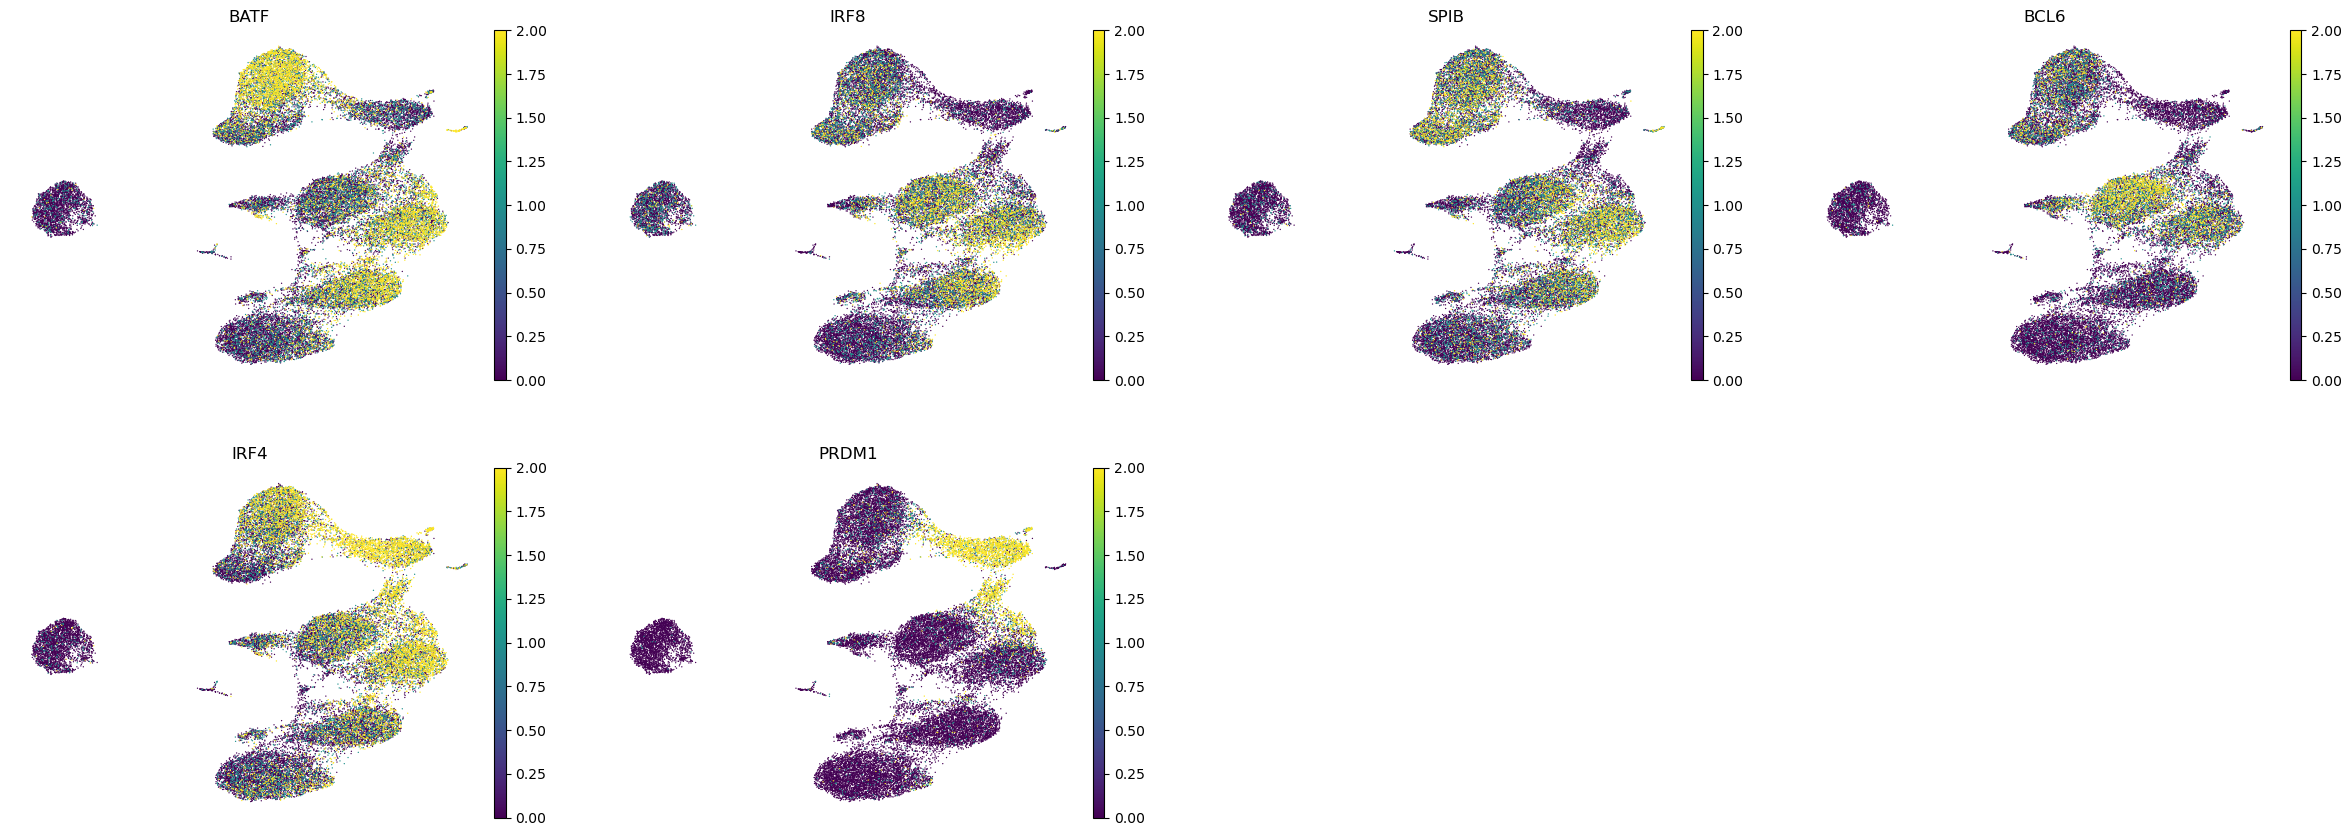

In [22]:
# pre imputation expression of 6 TFs
sc.pl.embedding(
    adata,
    basis="umap",
    layer="counts",
    color=["BATF","IRF8","SPIB","BCL6","IRF4","PRDM1"],
    vmin=0,
    vmax=2,
    frameon=False,
)
plt.show()

#### Impute only highly variable genes by using diffusion in the pca space of cells to get new nearest neighbors

In [23]:
import palantir

In [24]:
def feature_selection(adata, gene_list = None):
    sc.pp.highly_variable_genes(adata, flavor='cell_ranger',n_top_genes=3000) 
    # MODIFY FILTERED_GENES TO ADD GENES OF INTEREST
    # Overriding the bool_list to include TF of interest
    if gene_list is not None:
        for gene in gene_list:
            if adata.var['highly_variable'][gene] == False:
                adata.var['highly_variable'][gene] = True
    #subset the anndata for trajectory dimensionality reduction
    adata = adata[:, adata.var.highly_variable]
    return adata

In [25]:
# default pca function gives bad results (palantir.utils.run_pca(adata, n_components=50))
def dim_reduction(adata):
    #Scale before running PCA
    sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
    sc.pp.scale(adata, max_value=10)
    sc.pp.pca(adata)
    sc.pl.pca_variance_ratio(adata, n_pcs=20, log=True)
    return adata

In [26]:
TFs_of_importance = ["BATF","IRF8","SPIB","IRF4","PRDM1","BCL6"]
marker_list = ["IL10", "AICDA", "IL4R", "FCER2", "BCL6", "JUN", "CD69", "JCHAIN", "CD27", "CD38", "XBP1", "MZB1", "MKI67"]
TF_perturb_list = ["BATF3","EGR1","FOS","IKZF1","IRF1","JUNB","JUND","MEF2A","MEF2C","MYB","NFATC1","NFATC2","NFIL3","NFKB1","NFKB2","PAX5","RUNX1","SP3","SPI1","STAT1","STAT5A","TCF12","VDR","XBP1","ZBTB7A"]
gene_list = list(set(TFs_of_importance + TF_perturb_list + marker_list))
# subset the anndata to only include the highly variable genes
adata = feature_selection(adata, gene_list)
adata


View of AnnData object with n_obs × n_vars = 32418 × 3018
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap', 'sub_cell_type_colors', 'hvg'
    obsm: 'X_joint_umap_features', 'X_topic_compositions', 'X_umap', 'X_umap_features

In [27]:
# check if new adata has var names of interest from the TFs_of_importance list
print(adata.var.highly_variable[TFs_of_importance])
# print how many true values are in the highly_variable column
print(adata.var.highly_variable.sum())


BATF     True
IRF8     True
SPIB     True
IRF4     True
PRDM1    True
BCL6     True
Name: highly_variable, dtype: bool
3018


#### Check PCA to reduce dimensionality for diffusion step recalculation of cell-cell similarities

In [29]:
print(adata.X.shape)
print(adata.layers['counts'].shape)
print(adata.X.max())
print(adata.X.min())

(32418, 3018)
(32418, 3018)
7.3432217
0.0


In [ ]:
# maybe set the X layer to counts before getting pca?

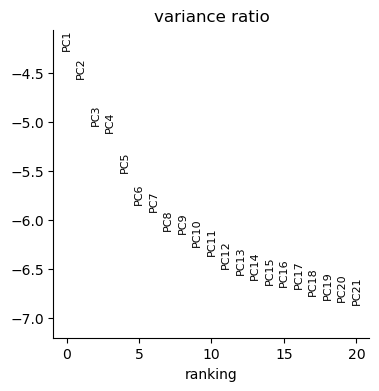

AnnData object with n_obs × n_vars = 32418 × 3018
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap', 'sub_cell_type_colors', 'hvg', 'pca'
    obsm: 'X_joint_umap_features', 'X_topic_compositions', 'X_umap', 'X

In [30]:
adata = dim_reduction(adata)
adata

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


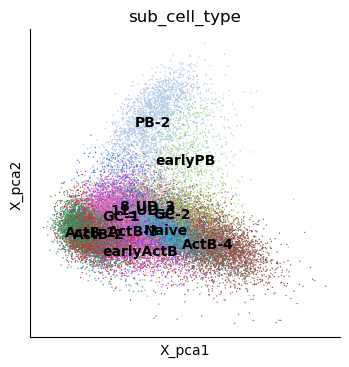

In [32]:
# plot using X_pca
sc.pl.embedding(adata, basis='X_pca', color=['sub_cell_type'], legend_loc='on data')


#### Run diffusion maps to get cell-cell similarities

In [34]:
palantir.utils.run_diffusion_maps(adata,n_components=10) #n_components, select from the plot above, knn = 30 by default for graph construction
adata


AnnData object with n_obs × n_vars = 32418 × 3018
    obs: 'cell_type_major', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'leiden', 'sub_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_major_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'topic_dendogram', 'umap', 'sub_cell_type_colors', 'hvg', 'pca', 'DM_EigenValues'
    obsm: 'X_joint_umap_features', 'X_topic_compositi

/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


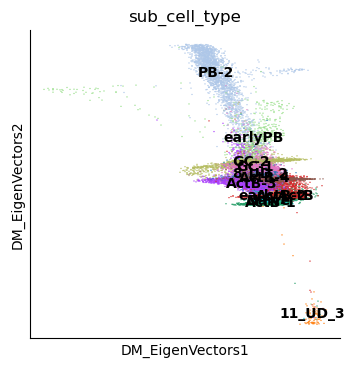

In [36]:
sc.pl.embedding(adata, basis='DM_EigenVectors', color=['sub_cell_type'], legend_loc='on data')


#### Run imputation 

In [37]:
palantir.utils.run_magic_imputation(adata)


array([[0.13219969, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.034524  , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0141546 ]], dtype=float32)

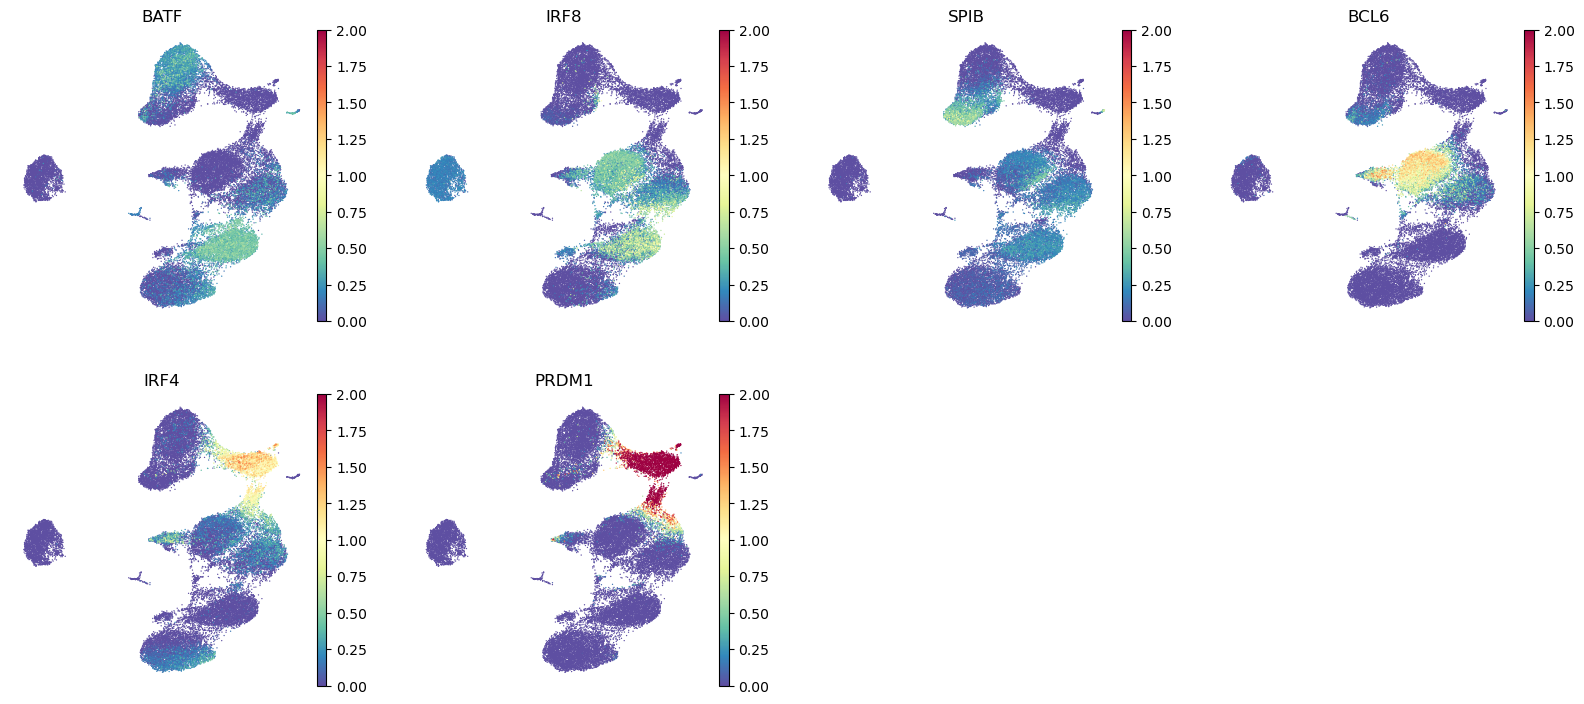

In [38]:
# plot post imputation expression of 5 TFs
sc.pl.embedding(
    adata,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=["BATF","IRF8","SPIB","BCL6","IRF4","PRDM1"],
    vmin=0,
    vmax=2,
    frameon=False,
)
plt.show()


In [39]:
# save the imputed adata
adata.write_h5ad(os.path.join(objects_path,"multiome_rna_imputed_v4.h5ad"))


# Filter cells for stream input

In [53]:
adata = sc.read_h5ad(os.path.join(objects_path,"multiome_rna_imputed_v4.h5ad"))

In [54]:
adata.obs['sub_cell_type'].cat.categories

Index(['8_UD_2', '11_UD_3', 'ActB-1', 'ActB-2', 'ActB-3', 'ActB-4', 'GC-1',
       'GC-2', 'Naive', 'PB-2', 'earlyActB', 'earlyPB'],
      dtype='object')

In [55]:
# subset the anndata to only include the cells that are in the categories of interest
adata=adata[adata.obs['sub_cell_type'].isin(['ActB-2', 'ActB-3', 'ActB-4', 'GC-1',
       'GC-2', 'PB-2', 'earlyActB', 'earlyPB'])]


In [56]:
leiden_color_dict = {
    'ActB-1': 'lightskyblue',     # light blue cluster at bottom
    'ActB-2': 'dodgerblue',       # darker blue cluster
    'ActB-4': 'mediumorchid',     # purple cluster
    'GC-1': 'limegreen',          # bright green cluster
    'ActB-3': 'darkblue',         # dark blue cluster
    'Naive': 'darkgray',          # gray cluster on left
    'GC-2': 'green',              # darker green cluster
    'PB-2': 'firebrick',          # red cluster
    'earlyPB': 'lightcoral',      # pink/coral cluster
    'earlyActB': 'teal'           # teal cluster
}

/tmp/ipykernel_97894/1686217596.py:8: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['sub_cell_type_colors'] = colors
/ocean/projects/cis240075p/asachan/.conda/envs/scvelo/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


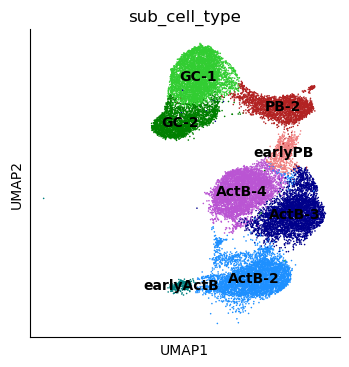

In [59]:
# First, make sure the colors are in the same order as the categories
categories = adata.obs['sub_cell_type'].cat.categories
colors = []
for cat in categories:
    colors.append(leiden_color_dict[cat])

# Set the colors in adata.uns
adata.uns['sub_cell_type_colors'] = colors

# Now plot without specifying color_map
sc.pl.umap(adata, color=['sub_cell_type'], legend_loc='on data')

In [60]:
# save the anndata
adata.write(os.path.join(objects_path,'stream_input_filtered_cells_v4.h5ad'))
